# Common Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Busniss underestanding

In [16]:
# BUSINESS OBJECTIVE
# ------------------
# Goal: Early detection of heart disease to reduce false negatives (high-risk patients missed).
# ML Task: Binary classification (0 = healthy, 1 = heart disease)
# Success Criteria:
# - Priority on Recall (Sensitivity)
# - ROC-AUC as global discriminative metric
# - Interpretable comparison across models


TARGET_NAME = "num"
POSITIVE_CLASS = 1
PRIORITY_METRIC = "recall"
UNKNOWN_VALUES = ["?", "unknown", "NA", "", "n/a", "nan", "NaN"]

# Data Understanding

Shape initiale: (294, 14)

1. Informations générales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         294 non-null    int64  
 1   sex         294 non-null    int64  
 2   cp          294 non-null    int64  
 3   trestbps    294 non-null    object 
 4   chol        294 non-null    object 
 5   fbs         294 non-null    object 
 6   restecg     294 non-null    object 
 7   thalach     294 non-null    object 
 8   exang       294 non-null    object 
 9   oldpeak     294 non-null    float64
 10  slope       294 non-null    object 
 11  ca          294 non-null    object 
 12  thal        294 non-null    object 
 13  num         294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB
None

2. Statistiques descriptives (numériques):
            count       mean       std   min   25%   50%   75%   max
age 

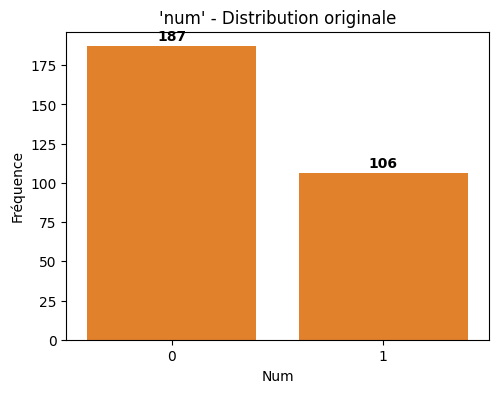

Ratio classe 1 / classe 0: 0.57
 Déséquilibre modéré détecté
Analyse de 5 colonnes numériques:


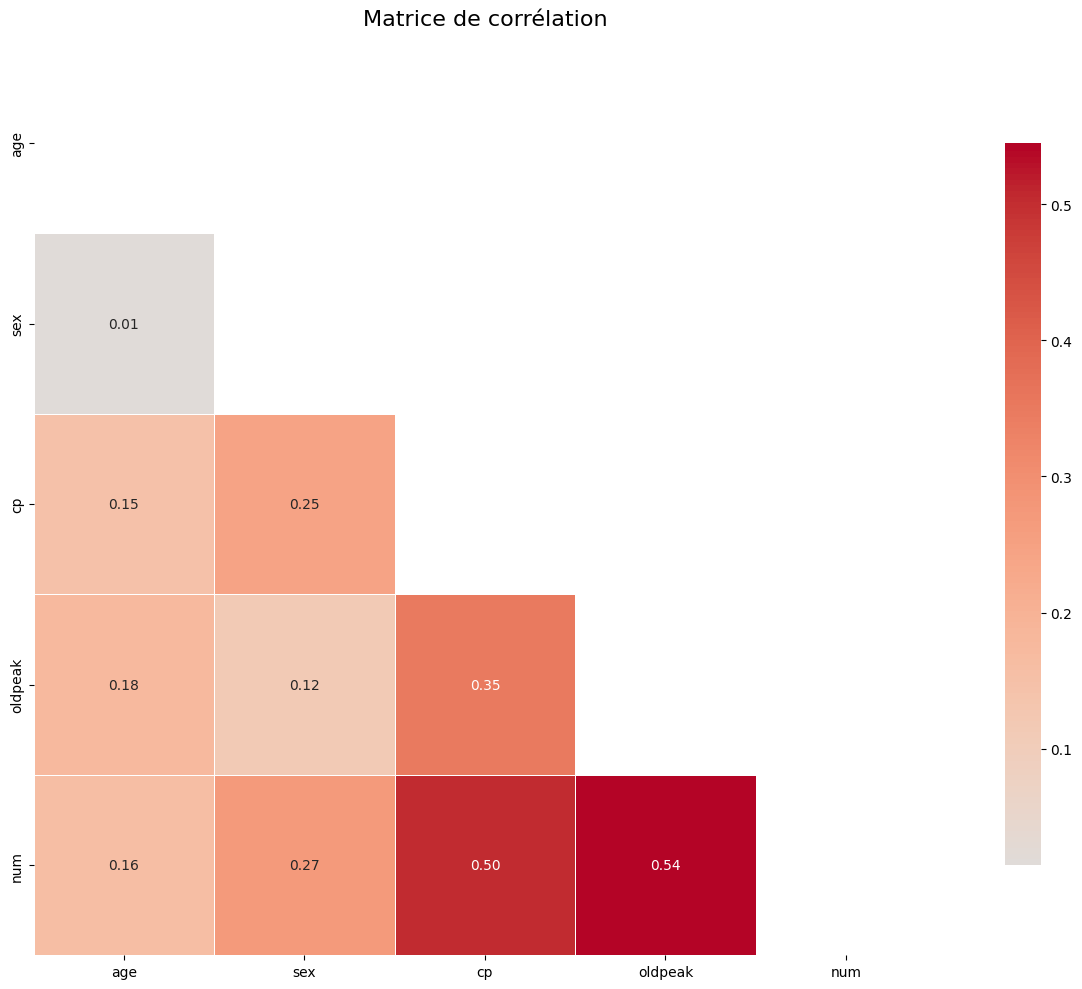


Corrélations avec 'num':
  oldpeak             :  0.545 (FORTE, positive)
  cp                  :  0.505 (FORTE, positive)
  sex                 :  0.270 (FAIBLE, positive)
  age                 :  0.160 (FAIBLE, positive)

Multicollinéarité potentielle (|corr| > 0.8):
  Aucune forte corrélation détectée entre features


In [17]:

# Load data
df = pd.read_csv("data (1).csv")
print(f"Shape initiale: {df.shape}")

#EDA complete:
print("\n1. Informations générales:")
print(df.info())

print("\n2. Statistiques descriptives (numériques):")
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print(df[numeric_cols].describe().T)
else:
    print("Aucune colonne numérique")

print("\n3. Statistiques descriptives (catégorielles):")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print(df[categorical_cols].describe().T)
else:
    print("Aucune colonne catégorielle")

#initial cleaning
df.columns = df.columns.str.strip()
for unknown_val in UNKNOWN_VALUES:
    df.replace(unknown_val, np.nan, inplace=True)

initial_rows = len(df)
df.drop_duplicates(inplace=True)
removed_rows = initial_rows - len(df)

print(f"\nAprès nettoyage:")
print(f"- Shape: {df.shape}")
print(f"- Doublons supprimés: {removed_rows}")

#analysis of missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Valeurs_manquantes': missing_values,
    'Pourcentage': missing_percentage
})
missing_df = missing_df[missing_df['Valeurs_manquantes'] > 0]
if len(missing_df) > 0:
    print("Colonnes avec valeurs manquantes:")
    print(missing_df.sort_values('Pourcentage', ascending=False))

    #global statistics
    total_missing = missing_values.sum()
    total_cells = df.shape[0] * df.shape[1]
    print(f"\nGlobal: {total_missing:,} valeurs manquantes sur {total_cells:,} cellules")
    print(f"Soit {(total_missing/total_cells*100):.2f}% des données")
else:
    print("✓ Aucune valeur manquante détectée")

#TARGET ANALYSIS
if TARGET_NAME not in df.columns:
    print(f"ERREUR: '{TARGET_NAME}' n'existe pas dans les colonnes")
    print(f"Colonnes disponibles: {list(df.columns)}")
    # Trouver une colonne candidate
    possible_targets = [col for col in df.columns if 'target' in col.lower() or 'class' in col.lower()]
    if possible_targets:
        print(f"\nSuggestions: {possible_targets}")
else:
    print(f"Distribution de '{TARGET_NAME}' (valeurs originales):")
    binary_dist = df[TARGET_NAME].value_counts().sort_index()
    print(binary_dist)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=TARGET_NAME, data=df, order=binary_dist.index)
    plt.title(f"'{TARGET_NAME}' - Distribution originale")
    plt.xlabel("Num")
    plt.ylabel("Fréquence")

    # Ajouter les counts sur les barres
    for i, count in enumerate(binary_dist):
        plt.text(i, count + 0.01*max(binary_dist), str(count),
                ha='center', va='bottom', fontweight='bold')

    sns.countplot(x=TARGET_NAME, data=df)
    plt.show()
# Class balance visualization
if 0 in binary_dist and 1 in binary_dist:
        ratio = binary_dist[1] / binary_dist[0]
        print(f"Ratio classe 1 / classe 0: {ratio:.2f}")

        if ratio > 2 or ratio < 0.5:
            print(" Déséquilibre important détecté")
        elif ratio > 1.5 or ratio < 0.67:
            print(" Déséquilibre modéré détecté")
        else:
            print("✓ Classes relativement équilibrées")
else:
        print(" Une des classes est absente!")


# Correlation overview
# Vérifier qu'on a des colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    print(f"Analyse de {len(numeric_cols)} colonnes numériques:")

    # Calcul de la corrélation
    corr_matrix = df[numeric_cols].corr(numeric_only=True)

    if corr_matrix.isnull().all().all():
        print("  Matrice de corrélation vide (toutes valeurs NaN)")
        print("   Raisons possibles:")
        print("   - Colonnes avec variance nulle")
        print("   - Valeurs manquantes dans toutes les colonnes")
        print("   - Types de données non numériques")
    else:
        # A. Heatmap
        plt.figure(figsize=(14, 10))

        # Masque triangulaire supérieur
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", center=0,
                   annot=True, fmt=".2f", linewidths=0.5, square=True,
                   cbar_kws={"shrink": 0.8})
        plt.title("Matrice de corrélation", fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()

        # B. Corrélations avec la cible
        if TARGET_NAME in corr_matrix.columns:
            print(f"\nCorrélations avec '{TARGET_NAME}':")
            target_corr = corr_matrix[TARGET_NAME].sort_values(key=abs, ascending=False)

            # Exclure la corrélation avec elle-même
            target_corr = target_corr[target_corr.index != TARGET_NAME]

            for feature, corr in target_corr.items():
                if pd.notna(corr):
                    strength = "FORTE" if abs(corr) > 0.5 else \
                              "MODÉRÉE" if abs(corr) > 0.3 else \
                              "FAIBLE" if abs(corr) > 0.1 else "NÉGLIGEABLE"
                    direction = "positive" if corr > 0 else "negative"
                    print(f"  {feature:20s}: {corr:6.3f} ({strength}, {direction})")

        # C. Multicollinéarité potentielle
        print(f"\nMulticollinéarité potentielle (|corr| > 0.8):")
        high_corr_pairs = []

        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_value = corr_matrix.iloc[i, j]
                if pd.notna(corr_value) and abs(corr_value) > 0.8:
                    col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                    high_corr_pairs.append((col1, col2, corr_value))

        if high_corr_pairs:
            for col1, col2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
                print(f"  {col1:15s} ↔ {col2:15s}: {corr:6.3f}")
        else:
            print("  Aucune forte corrélation détectée entre features")
else:
    print(f" Pas assez de colonnes numériques pour l'analyse: {len(numeric_cols)} trouvées")



# Data Preparation

In [18]:
def feature_engineering(X):
    X = X.copy()

    # FORCE numeric conversion
    for col in ["chol", "age", "trestbps", "thalach"]:
        if col in X.columns:
            X[col] = pd.to_numeric(X[col], errors="coerce")

    #  Safe feature engineering
    X["chol_age_ratio"] = X["chol"] / (X["age"] + 1)
    X["high_bp"] = (X["trestbps"] > 140).astype(int)
    X["age_thalach"] = X["age"] * X["thalach"]

    return X



X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]


X = feature_engineering(X)


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42
)

categorical = X.select_dtypes(exclude="number").columns.tolist()
numerical = X.select_dtypes(include="number").columns.tolist()


preprocessor = ColumnTransformer([
("num", Pipeline([
("imputer", SimpleImputer(strategy="median")),
("scaler", StandardScaler())
]), numerical),


("cat", Pipeline([
("imputer", SimpleImputer(strategy="most_frequent")),
("encoder", OneHotEncoder(handle_unknown="ignore"))
]), categorical)
])


# Modelling

**SGD: Logistic Regression**

In [19]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

logistic_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

logistic_pipeline.fit(X_train, y_train)
y_pred_logistic = logistic_pipeline.predict(X_test)
y_prob_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]


**K-Nearest Neighbors (KNN)**

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
y_prob_knn = knn_pipeline.predict_proba(X_test)[:, 1]


**Decision Tree (CART)**

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)
y_prob_dt = dt_pipeline.predict_proba(X_test)[:, 1]


**Random Forest**

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]


**Support Vector Machine (SVM)**

In [23]:
from sklearn.svm import SVC

svm_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", SVC(kernel="rbf", probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)
y_prob_svm = svm_pipeline.predict_proba(X_test)[:, 1]


**XGBoost**

In [24]:
from xgboost import XGBClassifier

xgb_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]


# Evaluation

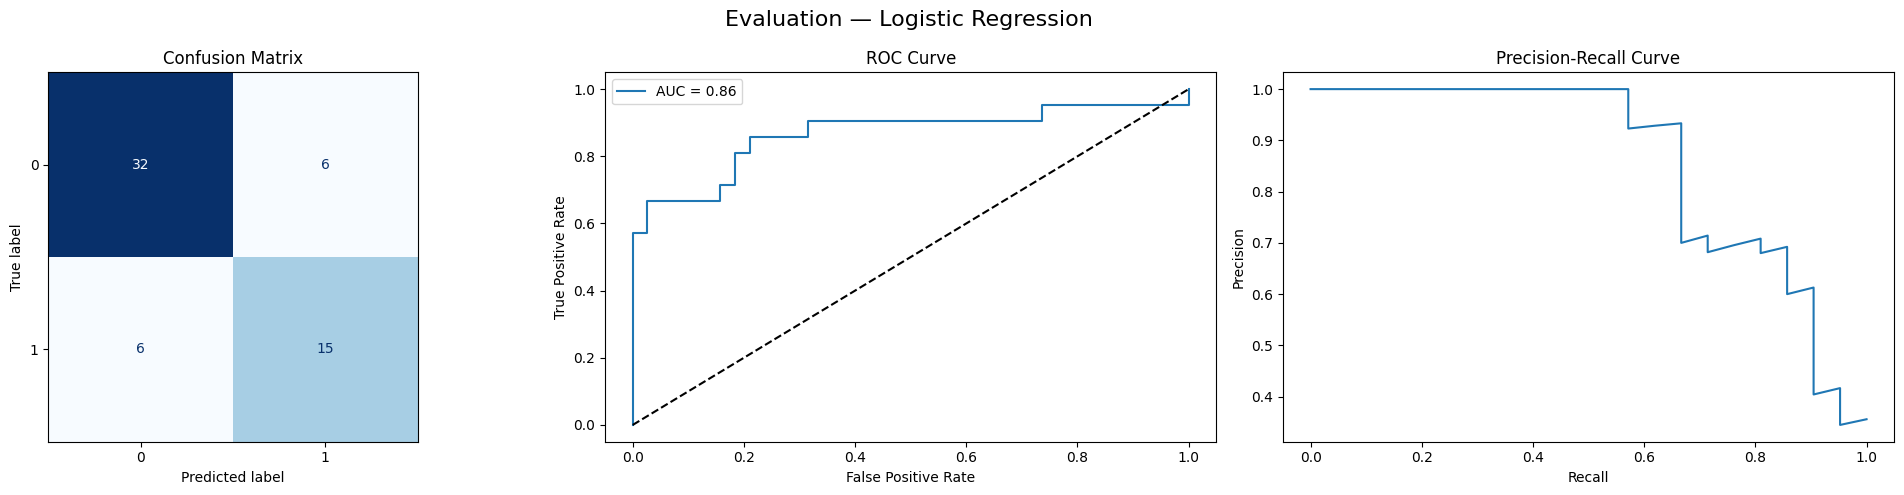

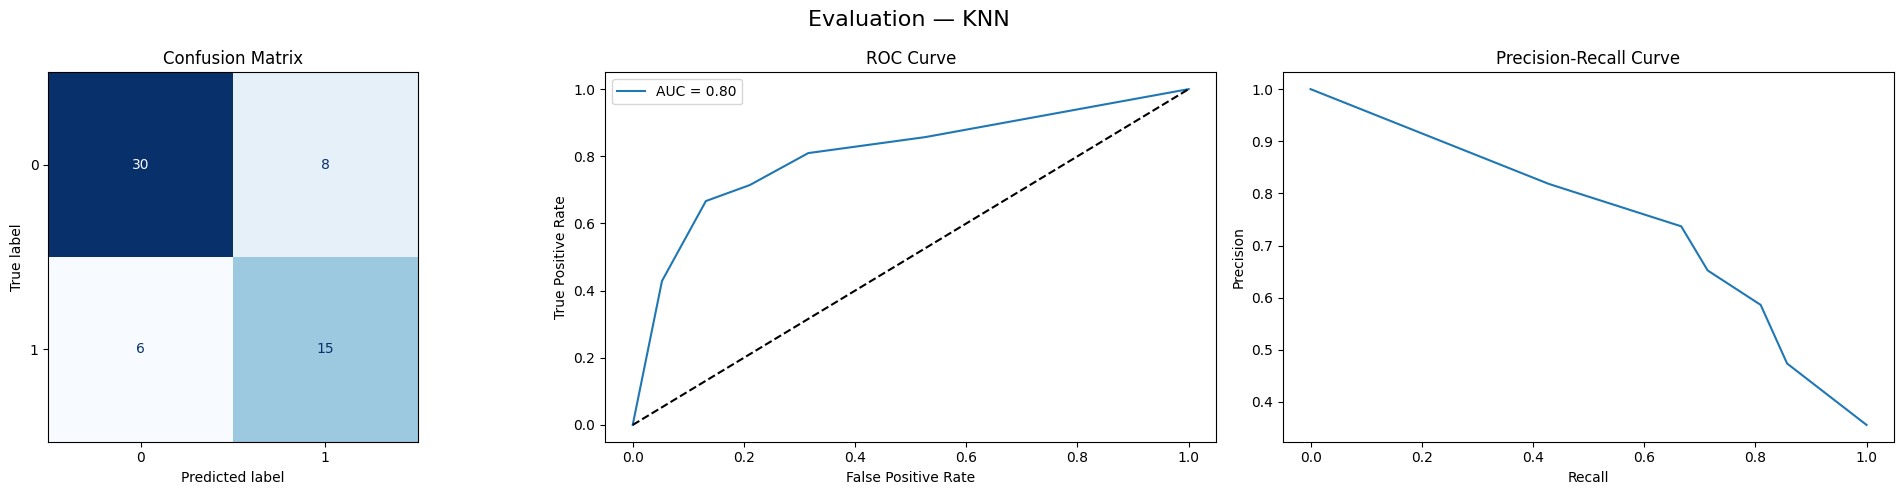

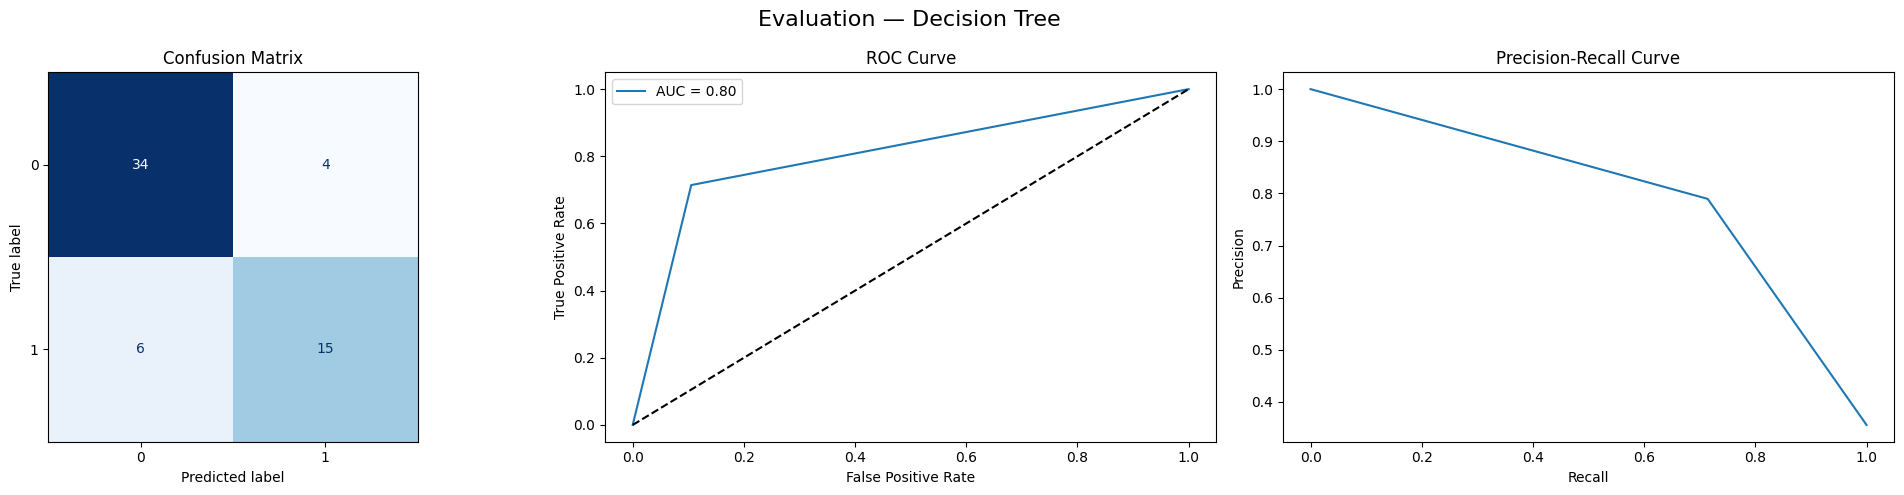

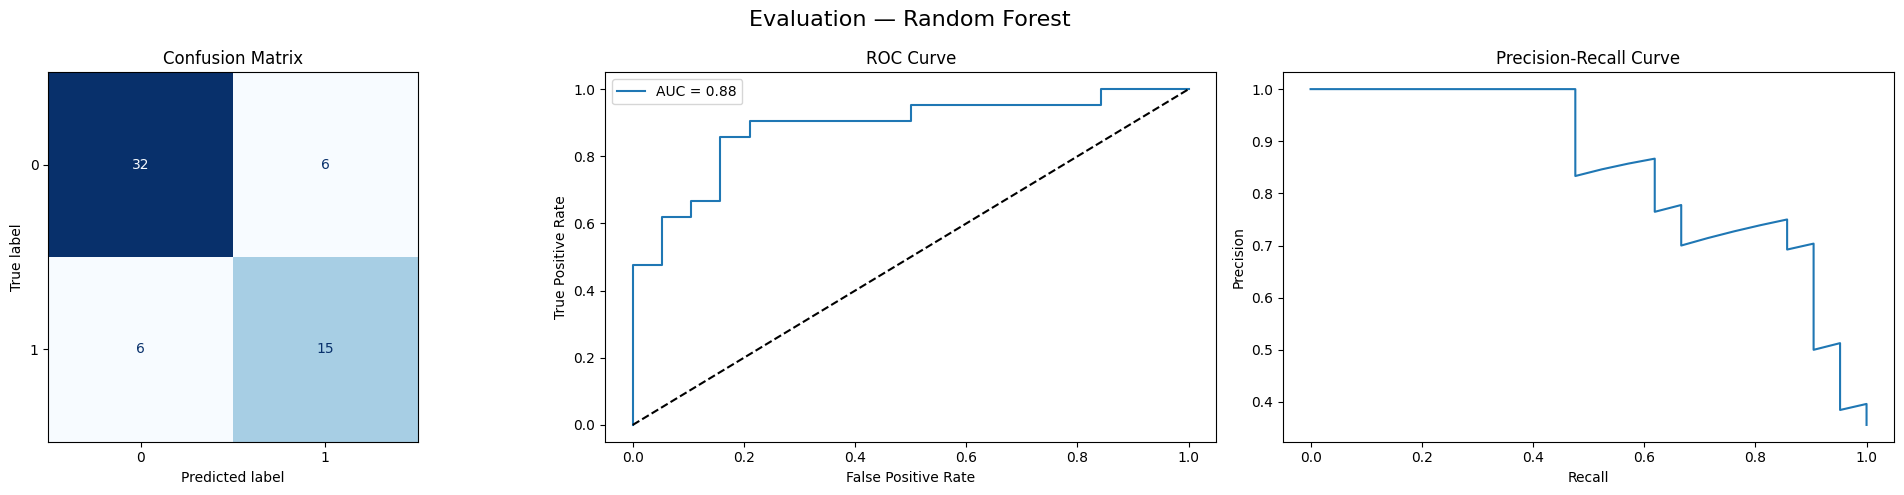

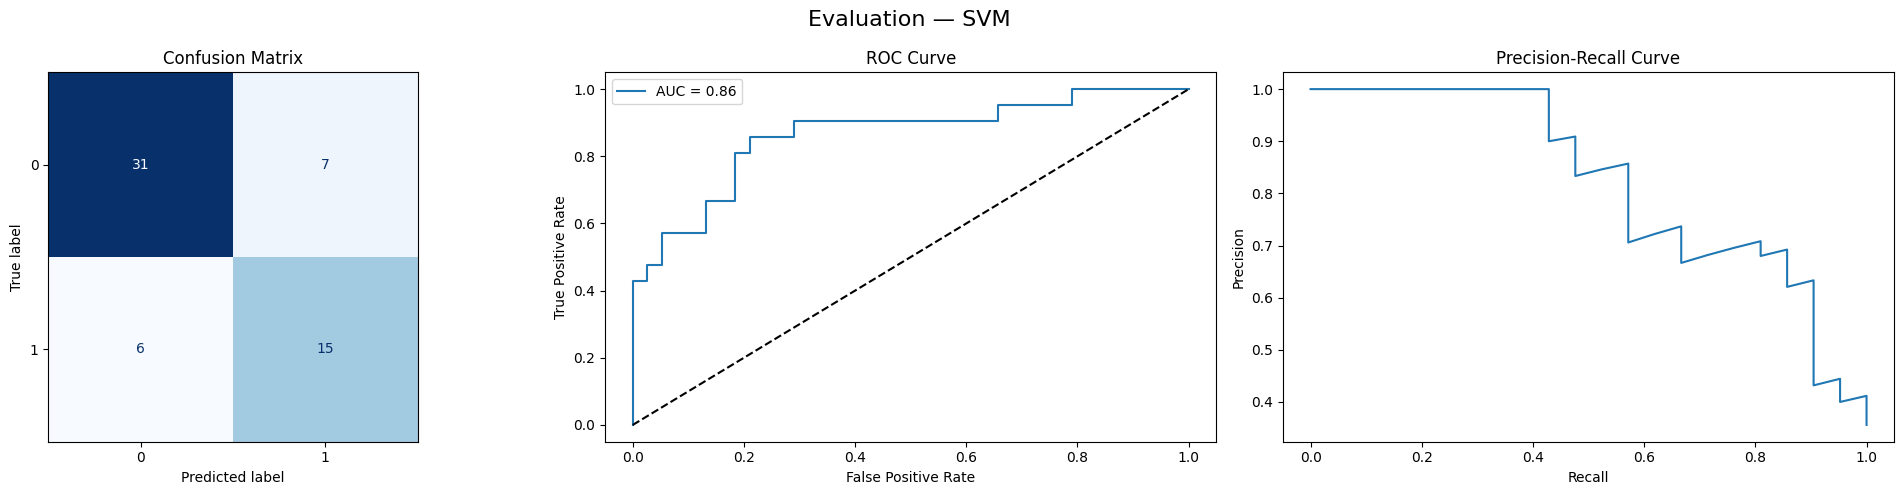

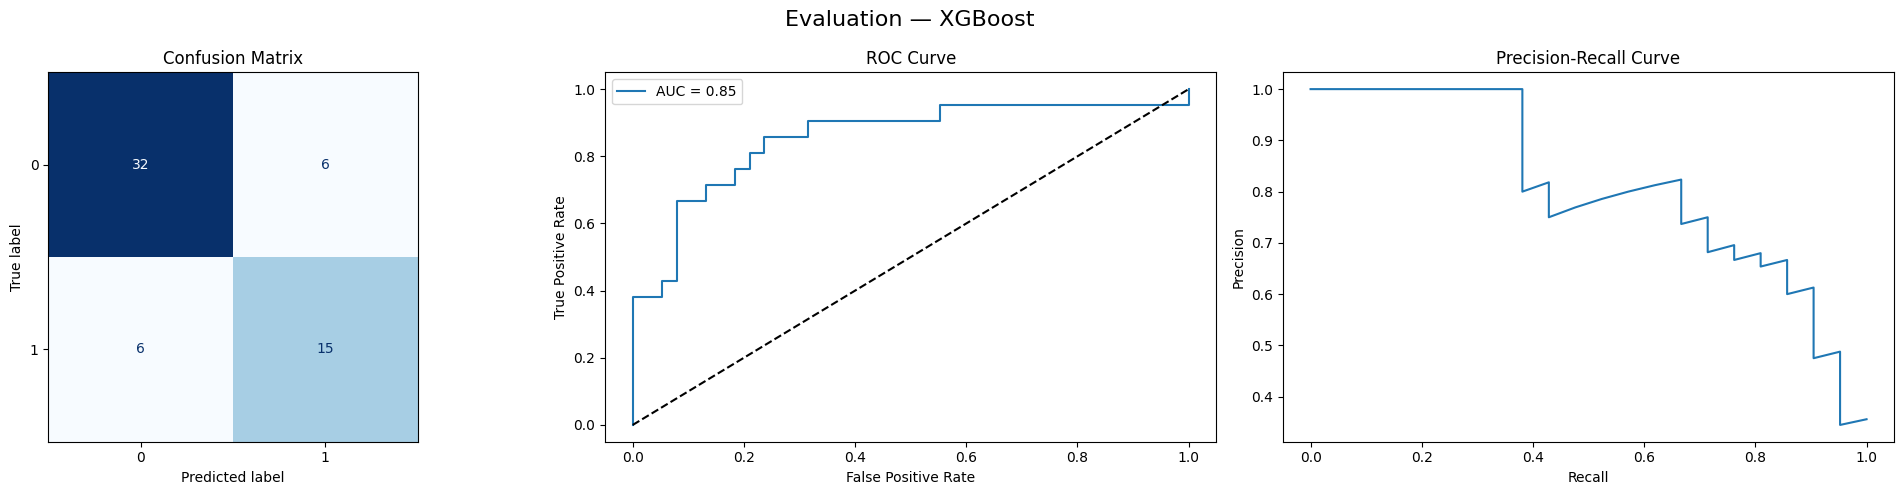

,Accuracy,Precision,Recall (Sensitivity),F1-Score,ROC-AUC
Logistic Regression,0.796610,0.714286,0.714286,0.714286,0.864662
KNN,0.762712,0.652174,0.714286,0.681818,0.804511
Decision Tree,0.830508,0.789474,0.714286,0.750000,0.804511
Random Forest,0.796610,0.714286,0.714286,0.714286,0.883459
SVM,0.779661,0.681818,0.714286,0.697674,0.862155
XGBoost,0.796610,0.714286,0.714286,0.714286,0.853383


In [28]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
results = {}
pipelines = {
    "Logistic Regression": logistic_pipeline,
    "KNN": knn_pipeline,
    "Decision Tree": dt_pipeline,
    "Random Forest": rf_pipeline,
    "SVM": svm_pipeline,
    "XGBoost": xgb_pipeline
}

for name, pipe in pipelines.items():

    #1 Entraînement

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    #2 Métriques numériques

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall (Sensitivity)": rec,
        "F1-Score": f1,
        "ROC-AUC": auc
    }

    #3 Courbes ROC & PR

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    #4 Matrice de confusion

    cm = confusion_matrix(y_test, y_pred)

    #5 VISUALISATION

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Evaluation — {name}", fontsize=16)

    # Matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title("Confusion Matrix")

    # ROC Curve
    axes[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    axes[1].plot([0, 1], [0, 1], "k--")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("ROC Curve")
    axes[1].legend()

    # Precision-Recall Curve
    axes[2].plot(recall, precision)
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].set_title("Precision-Recall Curve")

    plt.tight_layout()
    plt.show()

    results_df = (
    pd.DataFrame(results)
    .T
    .sort_values("Recall (Sensitivity)", ascending=False)
)

results_df



# Deployment Decision & Best Model Selection

In [29]:
print("MODEL COMPARISON SUMMARY\n")

# Affichage du tableau comparatif
display(
    results_df
    .style
    .format("{:.3f}")
    .background_gradient(
        subset=["Recall (Sensitivity)"],
        cmap="Greens"
    )
    .background_gradient(
        subset=["ROC-AUC"],
        cmap="Blues"
    )
)


print("\nStratégie de sélection du modèle :")
print("- Métrique principale   : Recall (Sensibilité)")
print("- Métrique secondaire   : ROC-AUC")
print("- Contexte              : Diagnostic médical (Prédiction de crise cardiaque)")
print("- Objectif              : Minimiser les faux négatifs")


# SÉLECTION DU MEILLEUR MODÈLE
results_sorted = results_df.sort_values(
    by=["Recall (Sensitivity)", "ROC-AUC"],
    ascending=[False, False]
)

best_model = results_sorted.index[0]
best_recall = results_df.loc[best_model, "Recall (Sensitivity)"]
best_auc = results_df.loc[best_model, "ROC-AUC"]

print("\nBEST MODEL SELECTED:")
print(f" Model        : {best_model}")
print(f" Recall       : {best_recall:.3f}")
print(f" ROC-AUC      : {best_auc:.3f}")


MODEL COMPARISON SUMMARY



,Accuracy,Precision,Recall (Sensitivity),F1-Score,ROC-AUC
Logistic Regression,0.797,0.714,0.714,0.714,0.865
KNN,0.763,0.652,0.714,0.682,0.805
Decision Tree,0.831,0.789,0.714,0.750,0.805
Random Forest,0.797,0.714,0.714,0.714,0.883
SVM,0.780,0.682,0.714,0.698,0.862
XGBoost,0.797,0.714,0.714,0.714,0.853



Stratégie de sélection du modèle :
- Métrique principale   : Recall (Sensibilité)
- Métrique secondaire   : ROC-AUC
- Contexte              : Diagnostic médical (Prédiction de crise cardiaque)
- Objectif              : Minimiser les faux négatifs

BEST MODEL SELECTED:
 Model        : Random Forest
 Recall       : 0.714
 ROC-AUC      : 0.883
